In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from img2vec import rgb2emb
import math
import os
import pandas as pd
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from joblib import dump, load

# Define the batch size for data processing
batch_size = 64


### read the data

In [2]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### add the path of the images

In [3]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])


train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)
train_data.head(5)

,user_id,face_id,original_image,age,gender,img_path
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,..\..\data\faces\9855553@N08\coarse_tilt_align...
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,..\..\data\faces\114841417@N06\coarse_tilt_ali...
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,..\..\data\faces\66870968@N06\coarse_tilt_alig...
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,..\..\data\faces\8187011@N06\coarse_tilt_align...
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,..\..\data\faces\114841417@N06\coarse_tilt_ali...


#### add column for check if the image exists
it will help us to detect if there is any missing image, or if there is any bug in the path construction

In [4]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

train_data.head(5)

,user_id,face_id,original_image,age,gender,img_path,img_exists
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,..\..\data\faces\9855553@N08\coarse_tilt_align...,True
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,..\..\data\faces\66870968@N06\coarse_tilt_alig...,True
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,..\..\data\faces\8187011@N06\coarse_tilt_align...,True
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True


In [5]:
def encode_gender_age(train_data, val_data, test_data):
    """Encodes gender and age combinations into a single label, handling unseen labels."""

    train_data['gender_age_combined'] = train_data['gender'].astype(str) + '_' + train_data['age'].astype(str)
    val_data['gender_age_combined'] = val_data['gender'].astype(str) + '_' + val_data['age'].astype(str)
    test_data['gender_age_combined'] = test_data['gender'].astype(str) + '_' + test_data['age'].astype(str)

    gender_age_encoder = LabelEncoder()
    train_data['gender_age_label'] = gender_age_encoder.fit_transform(train_data['gender_age_combined'])

    # Function to handle unseen labels
    def transform_with_unknown(data, encoder):
        known_classes = set(encoder.classes_)
        data['gender_age_label'] = data['gender_age_combined'].apply(
            lambda x: encoder.transform([x])[0] if x in known_classes else -1
        ) # assign -1 to unseen label.
        return data

    val_data = transform_with_unknown(val_data, gender_age_encoder)
    test_data = transform_with_unknown(test_data, gender_age_encoder)

    num_classes = len(gender_age_encoder.classes_)

    train_data.drop('gender_age_combined', axis=1, inplace=True)
    val_data.drop('gender_age_combined', axis=1, inplace=True)
    test_data.drop('gender_age_combined', axis=1, inplace=True)

    return train_data, val_data, test_data, num_classes, gender_age_encoder

train_data, val_data, test_data, num_classes, gender_age_encoder = encode_gender_age(train_data, val_data, test_data)

num_classes = len(gender_age_encoder.classes_)
print("gender_age classes:", gender_age_encoder.classes_)
train_data.head(5)

gender_age classes: ['f_(0, 2)' 'f_(15, 20)' 'f_(25, 32)' 'f_(38, 43)' 'f_(4, 6)' 'f_(48, 53)'
 'f_(60, 100)' 'f_(8, 23)' 'm_(0, 2)' 'm_(15, 20)' 'm_(25, 32)'
 'm_(38, 43)' 'm_(4, 6)' 'm_(48, 53)' 'm_(60, 100)' 'm_(8, 23)' 'u_(0, 2)'
 'u_(25, 32)' 'u_(60, 100)' 'u_(8, 23)']


,user_id,face_id,original_image,age,gender,img_path,img_exists,gender_age_label
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,..\..\data\faces\9855553@N08\coarse_tilt_align...,True,14
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True,9
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,..\..\data\faces\66870968@N06\coarse_tilt_alig...,True,10
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,..\..\data\faces\8187011@N06\coarse_tilt_align...,True,16
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True,1


### Filter out any rows where the image doesn't exist

In [6]:
train_data_filtered = train_data[train_data['img_exists'] == True]
val_data_filtered = val_data[val_data['img_exists'] == True]
test_data_filtered = test_data[test_data['img_exists'] == True]

### Define a generator function to process images in batches

In [7]:
def image_batch_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    num_batches = math.ceil(num_samples / batch_size)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)

        batch_paths = image_paths[start_idx:end_idx]
        batch_features = rgb2emb(batch_paths) / 255.0  # Normalize to [0,1]
        batch_labels = labels[start_idx:end_idx]

        yield batch_features, batch_labels


### Extract image paths and labels

In [8]:
train_image_paths = train_data_filtered['img_path'].tolist()
train_labels = train_data_filtered['gender_age_label'].values

val_image_paths = val_data_filtered['img_path'].tolist()
val_labels = val_data_filtered['gender_age_label'].values

test_image_paths = test_data_filtered['img_path'].tolist()
test_labels = test_data_filtered['gender_age_label'].values

### Print dataset sizes

In [9]:
print(f"Training samples: {len(train_image_paths)}")
print(f"Validation samples: {len(val_image_paths)}")
print(f"Test samples: {len(test_image_paths)}")
print(f"Number of classes: {num_classes}")


Training samples: 11856
Validation samples: 2964
Test samples: 3731
Number of classes: 20


### Extract features for training and validation


In [10]:
print("Extracting features for training data...")
print(f"Processing all {len(train_image_paths)} training samples")

Extracting features for training data...
Processing all 11856 training samples


### Define a function to extract features in batches


In [11]:
def extract_features_in_batches(image_paths, batch_size=64):
    """Extract features from images in batches to manage memory."""
    num_samples = len(image_paths)
    num_batches = math.ceil(num_samples / batch_size)
    all_features = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        
        print(f"\rProcessing batch {i+1}/{num_batches}", end="")
        
        batch_paths = image_paths[start_idx:end_idx]
        batch_features = rgb2emb(batch_paths) / 255.0  # Normalize to [0,1]
        
        all_features.append(batch_features)
    
    print("\nFeature extraction complete.")
    return np.vstack(all_features)


In [12]:
X_train = extract_features_in_batches(train_image_paths, batch_size=batch_size)
y_train = train_labels

print("Extracting features for validation data...")
print(f"Processing all {len(val_image_paths)} validation samples")

X_val = extract_features_in_batches(val_image_paths, batch_size=batch_size)
y_val = val_labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 954ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 857ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 850ms/step
Processing batch 5/186WARNING:tensorflow:5 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021FE29695A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 831ms/step
Processing batch 6/186WARNING:tensorflow:6 out of the last 1

### Create a pipeline with scaling and LinearSVC
This is much more memory efficient for large datasets

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features for better performance
    ('svm', LinearSVC(
        C=1.0,                    # Regularization parameter
        penalty='l2',             # Penalty norm (l2 is default)
        loss='squared_hinge',     # Loss function
        dual=False,               # Prefer dual=False when n_samples > n_features
        max_iter=1000,            # Increase if needed for convergence
        class_weight='balanced',  # Handle class imbalance
        verbose=1,
        random_state=42
    ))
])

### define the model and train it

In [20]:
print("Checking class distribution...")
class_counts = np.bincount(y_train)
min_samples = np.min(class_counts[class_counts > 0])  # Minimum samples in any class
print(f"Minimum samples in any class: {min_samples}")

if min_samples >= 3:
    # Use cross-validation calibration if all classes have at least 3 samples
    print("Training calibrated model with cross-validation...")
    model = CalibratedClassifierCV(pipeline, cv=3)
    model.fit(X_train, y_train)
else:
    # Use a simpler calibration method for rare classes
    print("Training with simplified calibration due to rare classes...")
    # First train the pipeline
    pipeline.fit(X_train, y_train)
    
    # Then calibrate without cross-validation (use 'sigmoid' method)
    model = CalibratedClassifierCV(pipeline, cv='prefit', method='sigmoid')
    model.fit(X_train, y_train)

Checking class distribution...
Minimum samples in any class: 1
Training with simplified calibration due to rare classes...
[LibLinear]

C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


### Evaluate the model on test data

In [21]:
# Evaluate the model
print("Evaluating the model...")
train_preds = model.predict(X_train)
train_accuracy = (train_preds == y_train).mean()
print(f"Training Accuracy: {train_accuracy:.4f}")

val_preds = model.predict(X_val)
val_accuracy = (val_preds == y_val).mean()
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Test the model on the entire test set
print(f"Extracting features for all {len(test_image_paths)} test samples...")
X_test = extract_features_in_batches(test_image_paths, batch_size=batch_size)
y_test = test_labels

test_preds = model.predict(X_test)
test_accuracy = (test_preds == y_test).mean()
print(f"Test Accuracy: {test_accuracy:.4f}")


Evaluating the model...
Training Accuracy: 0.9988
Validation Accuracy: 0.4922
Extracting features for all 3731 test samples...
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 997ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 996ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 974ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 951ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 861ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 820ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 939ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 953ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 967ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 938ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
2/2

### Visualize results

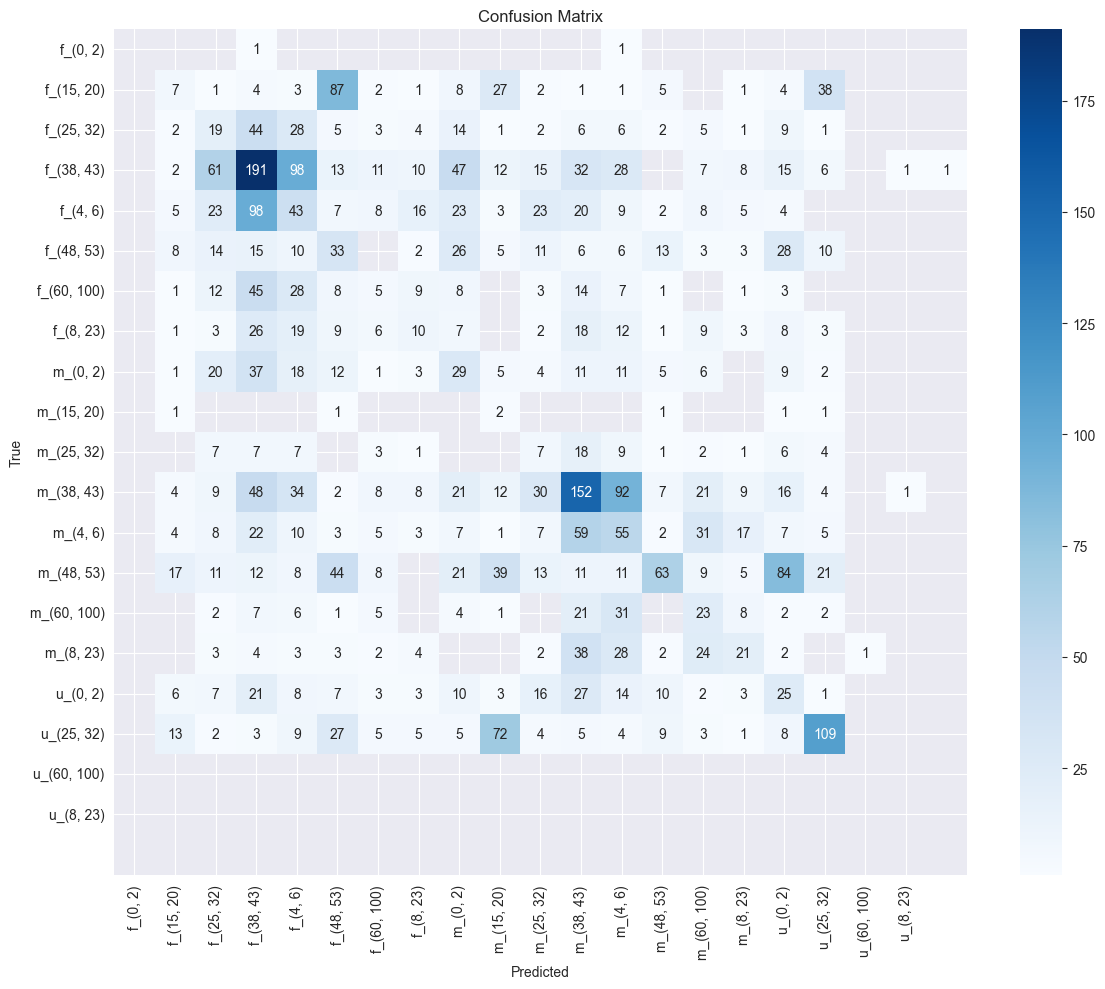

In [22]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, test_preds)
# Use a mask for the heatmap to only show cells with non-zero values
mask = cm == 0
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', mask=mask,
           xticklabels=gender_age_encoder.classes_,
           yticklabels=gender_age_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('linear_svc_confusion_matrix.png')
plt.show()

### Save the model

In [26]:
dump(model, 'linear_svc_gender_age_classifier.joblib')
dump(gender_age_encoder, 'gender_age_encoder.joblib')
print("Model saved successfully.")

Model saved successfully.


In [27]:
# Function to predict gender_age range for a new image
def predict_gender_age(image_path, model, gender_age_encoder):
    """Predict gender and age for a given face image."""
    # Extract features
    features = rgb2emb([image_path]) / 255.0
    
    # Apply the same scaling used during training (if using a pipeline with StandardScaler)
    if hasattr(model, 'named_steps') and 'scaler' in model.named_steps:
        features = model.named_steps['scaler'].transform(features)
    
    # Make prediction
    pred_class = model.predict(features)[0]
    
    # Get class probabilities if available
    if hasattr(model, 'predict_proba'):
        pred_probs = model.predict_proba(features)[0]
        confidence = pred_probs[pred_class]
    else:
        # For LinearSVC without calibration, we can't get probabilities
        # Use decision function instead as a rough proxy for confidence
        decision_values = model.decision_function(features)
        # Normalize to [0, 1] range roughly
        confidence = 1 / (1 + np.exp(-np.abs(decision_values[0][pred_class])))
    
    # Convert to gender_age range
    pred_gender_age_range = gender_age_encoder.classes_[pred_class]
    
    return pred_gender_age_range, confidence

# Example usage:
"""
# Load the model
image_path = "path/to/new/face/image.jpg"
model = load('linear_svc_gender_age_classifier.joblib')
gender_age_encoder = load('gender_age_encoder.joblib')

# Make prediction
pred_gender_age, confidence = predict_gender_age(image_path, model, gender_age_encoder)
print(f"Predicted gender_age range: {pred_gender_age} with confidence {confidence:.2f}")
"""


'\n# Load the model\nimage_path = "path/to/new/face/image.jpg"\nmodel = load(\'linear_svc_gender_age_classifier.joblib\')\ngender_age_encoder = load(\'gender_age_encoder.joblib\')\n\n# Make prediction\npred_gender_age, confidence = predict_gender_age(image_path, model, gender_age_encoder)\nprint(f"Predicted gender_age range: {pred_gender_age} with confidence {confidence:.2f}")\n'